In [1]:
# ==========================================
# FULL PIPELINE: SETUP -> VQ-VAE -> TRANSFORMER -> INFERENCE
# ==========================================

import os
import sys
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 1. Install Transformers (if needed)
try:
    from transformers import DistilBertTokenizer
except ImportError:
    os.system('pip install transformers')
    from transformers import DistilBertTokenizer

# 2. Mount Drive
from google.colab import drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# ==========================================
# CONFIGURATION
# ==========================================
class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # PATHS
    IMG_DIR = '/content/drive/MyDrive/DALEEtrain/images'
    TXT_DIR = '/content/drive/MyDrive/DALEEtrain/labels'

    img_size = 64
    batch_size = 16

    # Model Params
    embedding_dim = 64
    num_embeddings = 512
    commitment_cost = 0.25

    # Training Params
    vq_epochs = 40       # Increased for better quality
    trans_epochs = 40    # Increased for better text mapping

cfg = Config()

# ==========================================
# DATASET
# ==========================================
class FloorPlanDataset(Dataset):
    def __init__(self, img_dir, txt_dir, tokenizer, transform=None):
        self.img_dir = img_dir
        self.txt_dir = txt_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.data_pairs = []

        if not os.path.exists(img_dir):
            print(f"❌ Error: Image path '{img_dir}' not found.")
            return

        all_files = os.listdir(img_dir)
        img_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg'))]

        print(f"Scanning {len(img_files)} images...")

        for filename in img_files:
            # Match "0020.png" -> "20.txt"
            name_part = os.path.splitext(filename)[0]
            try:
                file_id = int(name_part)
                txt_filename = f"{file_id}.txt"
                txt_path = os.path.join(txt_dir, txt_filename)

                if os.path.exists(txt_path):
                    self.data_pairs.append((os.path.join(img_dir, filename), txt_path))
            except ValueError:
                continue

        print(f"✅ Found {len(self.data_pairs)} valid image-text pairs.")

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        img_path, txt_path = self.data_pairs[idx]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        with open(txt_path, 'r') as f:
            text = f.read().strip()

        encoded = self.tokenizer(text, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
        return image, encoded['input_ids'].squeeze(0)

# Setup Data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
transform = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = FloorPlanDataset(cfg.IMG_DIR, cfg.TXT_DIR, tokenizer, transform)
if len(dataset) > 0:
    dataloader = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True)
else:
    print("❌ STOPPING: No data found.")
    dataloader = None

# ==========================================
# ROBUST VQ-VAE MODEL (Fixes White Images)
# ==========================================
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(ResidualBlock, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels, num_residual_hiddens, 3, 1, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(num_residual_hiddens, num_hiddens, 1, 1, bias=False)
        )
    def forward(self, x):
        return x + self._block(x)

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self._commitment_cost = commitment_cost
        self.embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self.embedding.weight.data.uniform_(-0.1, 0.1)

    def forward(self, inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        flat_input = inputs.view(-1, self._embedding_dim)
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.embedding.weight.t()))

        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        quantized = self.embedding(encoding_indices).view(input_shape)

        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        return quantized, loss, encoding_indices

class VQVAE(nn.Module):
    def __init__(self):
        super(VQVAE, self).__init__()
        num_hiddens = 128
        num_residual_hiddens = 32

        self.encoder = nn.Sequential(
            nn.Conv2d(3, num_hiddens//2, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(num_hiddens//2, num_hiddens, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(num_hiddens, num_hiddens, 3, 1, 1),
            ResidualBlock(num_hiddens, num_hiddens, num_residual_hiddens),
            ResidualBlock(num_hiddens, num_hiddens, num_residual_hiddens),
            nn.BatchNorm2d(num_hiddens), # Fix for posterior collapse
            nn.Conv2d(num_hiddens, cfg.embedding_dim, 1, 1, 0)
        )
        self.quantizer = VectorQuantizer(cfg.num_embeddings, cfg.embedding_dim, cfg.commitment_cost)
        self.decoder = nn.Sequential(
            nn.Conv2d(cfg.embedding_dim, num_hiddens, 3, 1, 1),
            ResidualBlock(num_hiddens, num_hiddens, num_residual_hiddens),
            ResidualBlock(num_hiddens, num_hiddens, num_residual_hiddens),
            nn.ConvTranspose2d(num_hiddens, num_hiddens//2, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(num_hiddens//2, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        quantized, loss, _ = self.quantizer(z)
        x_recon = self.decoder(quantized)
        return x_recon, loss



Mounting Google Drive...
Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Scanning 149 images...
✅ Found 149 valid image-text pairs.



--- Phase 1: Training VQ-VAE ---
VQ-VAE Epoch 5/40 | Loss: 0.7188


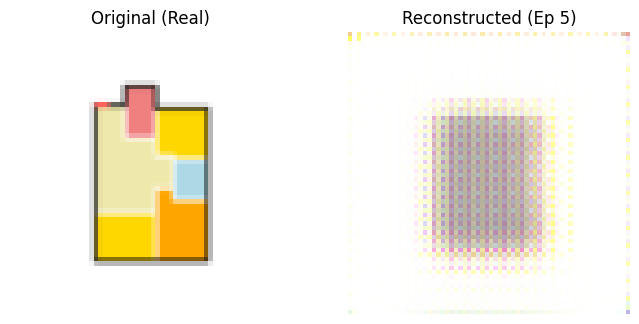

VQ-VAE Epoch 10/40 | Loss: 0.3348


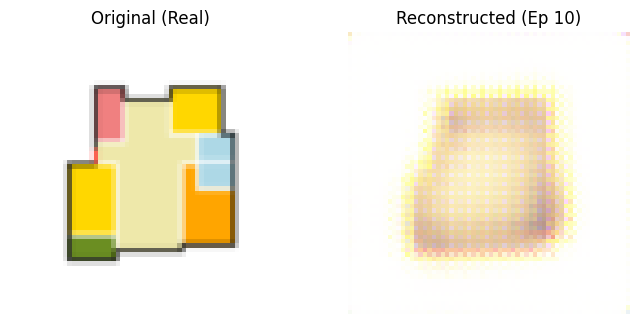

VQ-VAE Epoch 15/40 | Loss: 0.3109


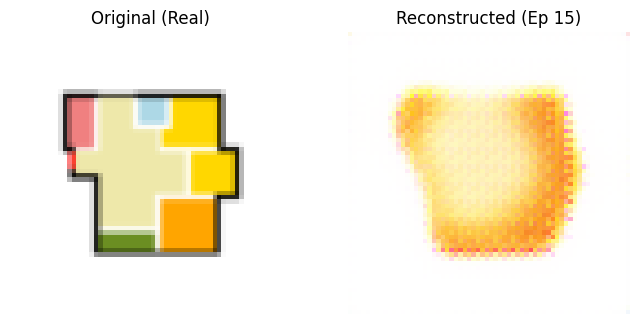

VQ-VAE Epoch 20/40 | Loss: 0.3933


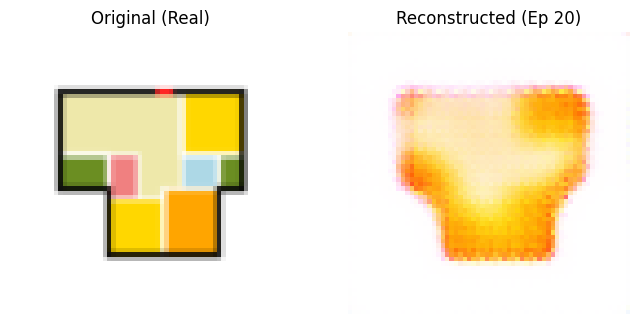

VQ-VAE Epoch 25/40 | Loss: 0.4286


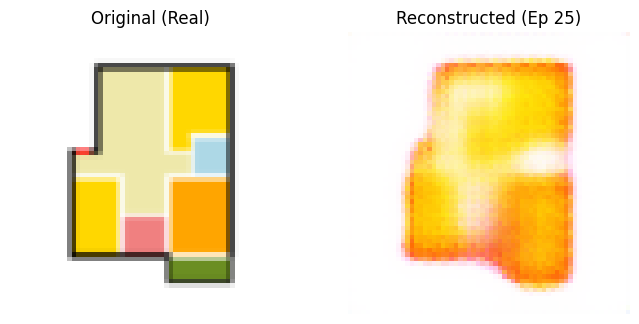

VQ-VAE Epoch 30/40 | Loss: 0.3701


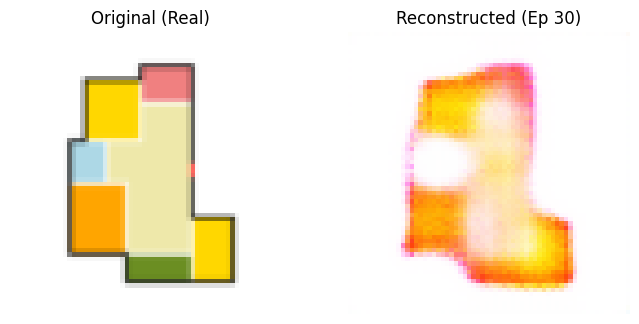

VQ-VAE Epoch 35/40 | Loss: 0.2826


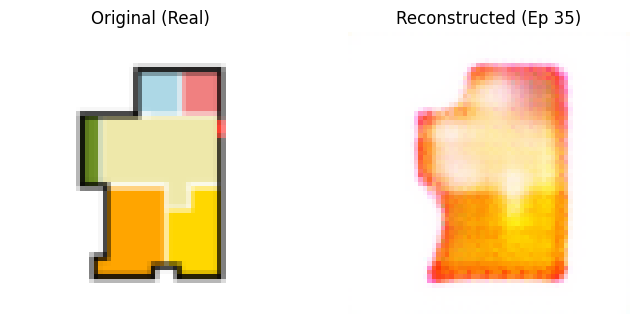

VQ-VAE Epoch 40/40 | Loss: 0.2366


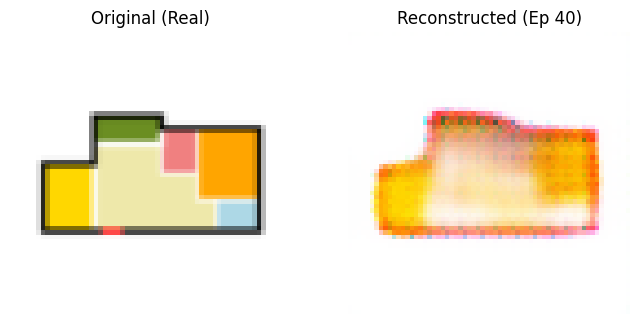

In [2]:
# ==========================================
# TRAINING VQ-VAE (With Side-by-Side Comparison)
# ==========================================
if dataloader:
    vqvae = VQVAE().to(cfg.device)
    optimizer_vq = optim.Adam(vqvae.parameters(), lr=3e-4) # Lower LR for stability
    criterion_vq = nn.L1Loss() # Better for sharp edges

    print("\n--- Phase 1: Training VQ-VAE ---")
    for epoch in range(cfg.vq_epochs):
        total_loss = 0
        for images, _ in dataloader:
            images = images.to(cfg.device)
            optimizer_vq.zero_grad()

            # Forward pass
            recon_images, vq_loss = vqvae(images)

            # Loss calculation
            loss = criterion_vq(recon_images, images) + vq_loss
            loss.backward()
            optimizer_vq.step()
            total_loss += loss.item()

        # --- VISUALIZATION (Every 5 epochs) ---
        if (epoch+1) % 5 == 0:
            avg_loss = total_loss / len(dataloader)
            print(f"VQ-VAE Epoch {epoch+1}/{cfg.vq_epochs} | Loss: {avg_loss:.4f}")

            vqvae.eval() # Switch to eval mode for visualization
            with torch.no_grad():
                # 1. Get the first image from the current batch
                orig_tensor = images[0]

                # 2. Reconstruct it
                # Add batch dim (1, 3, 64, 64) -> pass through model -> remove batch dim
                recon_tensor, _ = vqvae(orig_tensor.unsqueeze(0))
                recon_tensor = recon_tensor.squeeze(0)

                # 3. Prepare for Plotting (Tensor -> Numpy, Denormalize)
                # Permute: (C, H, W) -> (H, W, C)
                orig_img = orig_tensor.permute(1, 2, 0).cpu().numpy()
                recon_img = recon_tensor.permute(1, 2, 0).cpu().numpy()

                # Denormalize (-1 to 1) -> (0 to 1)
                orig_img = (orig_img * 0.5) + 0.5
                recon_img = (recon_img * 0.5) + 0.5

                # Clip values to be safe
                orig_img = np.clip(orig_img, 0, 1)
                recon_img = np.clip(recon_img, 0, 1)

                # 4. Plot Side-by-Side
                fig, axes = plt.subplots(1, 2, figsize=(8, 4))

                # Original
                axes[0].imshow(orig_img)
                axes[0].set_title("Original (Real)")
                axes[0].axis('off')

                # Reconstructed
                axes[1].imshow(recon_img)
                axes[1].set_title(f"Reconstructed (Ep {epoch+1})")
                axes[1].axis('off')

                plt.show()

            vqvae.train() # Switch back to training mode

    # Final Freeze
    vqvae.eval()
    for param in vqvae.parameters():
        param.requires_grad = False

In [3]:
# ==========================================
# TRANSFORMER MODEL (Fixed Dimensions)
# ==========================================
class FloorPlanTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.sos_token = cfg.num_embeddings
        self.text_emb = nn.Embedding(tokenizer.vocab_size, 512)
        self.text_pos = nn.Parameter(torch.randn(1, 64, 512))
        self.img_emb = nn.Embedding(cfg.num_embeddings + 1, 512)
        self.img_pos = nn.Parameter(torch.randn(1, 257, 512)) # SOS + 256

        layer = nn.TransformerDecoderLayer(d_model=512, nhead=8, batch_first=True)
        self.transformer = nn.TransformerDecoder(layer, num_layers=6)
        self.fc_out = nn.Linear(512, cfg.num_embeddings)

    def forward(self, text_ids, img_indices):
        B = text_ids.shape[0]
        text_feat = self.text_emb(text_ids) + self.text_pos[:, :text_ids.shape[1], :]

        sos = torch.full((B, 1), self.sos_token, device=cfg.device)
        img_in = torch.cat([sos, img_indices], dim=1)

        # Safe slicing of positional embeddings
        img_feat = self.img_emb(img_in) + self.img_pos[:, :img_in.shape[1], :]

        full_seq = torch.cat([text_feat, img_feat], dim=1)

        mask = torch.triu(torch.ones(full_seq.shape[1], full_seq.shape[1]) * float('-inf'), diagonal=1).to(cfg.device)
        mask[:64, :64] = 0

        out = self.transformer(full_seq, full_seq, tgt_mask=mask)
        return self.fc_out(out[:, 64:, :])



In [6]:
# ==========================================
# TRAINING TRANSFORMER
# ==========================================
if dataloader:
    transformer = FloorPlanTransformer().to(cfg.device)
    optimizer_gpt = optim.Adam(transformer.parameters(), lr=3e-4)
    criterion_gpt = nn.CrossEntropyLoss()

    print("\n--- Phase 2: Training Transformer ---")
    for epoch in range(500):
        total_loss = 0
        transformer.train()
        for images, text_ids in dataloader:
            images = images.to(cfg.device)
            text_ids = text_ids.to(cfg.device)

            with torch.no_grad():
                z = vqvae.encoder(images)
                _, _, indices = vqvae.quantizer(z)
                indices = indices.view(images.shape[0], -1)

            optimizer_gpt.zero_grad()
            logits = transformer(text_ids, indices[:, :-1]) # Predict next token
            loss = criterion_gpt(logits.reshape(-1, cfg.num_embeddings), indices.reshape(-1))
            loss.backward()
            optimizer_gpt.step()
            total_loss += loss.item()

        if (epoch+1) % 10 == 0:
            print(f"Transformer Epoch {epoch+1}/{500} | Loss: {total_loss/len(dataloader):.4f}")




--- Phase 2: Training Transformer ---
Transformer Epoch 10/500 | Loss: 0.9180
Transformer Epoch 20/500 | Loss: 0.5413
Transformer Epoch 30/500 | Loss: 0.0494
Transformer Epoch 40/500 | Loss: 0.0126
Transformer Epoch 50/500 | Loss: 0.0086
Transformer Epoch 60/500 | Loss: 0.0063
Transformer Epoch 70/500 | Loss: 0.0032
Transformer Epoch 80/500 | Loss: 0.0033
Transformer Epoch 90/500 | Loss: 0.0020
Transformer Epoch 100/500 | Loss: 0.0028
Transformer Epoch 110/500 | Loss: 0.0020
Transformer Epoch 120/500 | Loss: 0.0017
Transformer Epoch 130/500 | Loss: 0.0026
Transformer Epoch 140/500 | Loss: 0.0010
Transformer Epoch 150/500 | Loss: 0.0037
Transformer Epoch 160/500 | Loss: 0.0010
Transformer Epoch 170/500 | Loss: 0.0006
Transformer Epoch 180/500 | Loss: 0.0022
Transformer Epoch 190/500 | Loss: 0.0015
Transformer Epoch 200/500 | Loss: 0.0017
Transformer Epoch 210/500 | Loss: 0.0022
Transformer Epoch 220/500 | Loss: 0.0036
Transformer Epoch 230/500 | Loss: 0.0014
Transformer Epoch 240/500 |

Design a house floor plan with an east-facing living room at the center. Kitchen is in the south middle between living room and bathroom. Bathroom (10×6 ft) is in the east–south middle corner between kitchen and living room. Common Room 1 (10×10 ft) is in the west–north middle between living room and Common Room 2. Common Room 2 (10×10 ft) is at the north center between Common Room 1 and the master bedroom. Master bedroom (10×14 ft) is in the north–east middle between balcony and storage. Balcony (10×6 ft) is at the north corner near Common Room 2 and master bedroom. Storage room (10×8 ft) is at the east corner between master bedroom and living room.
An error occurred while loading or displaying the image: title() missing 1 required positional argument: 'label'


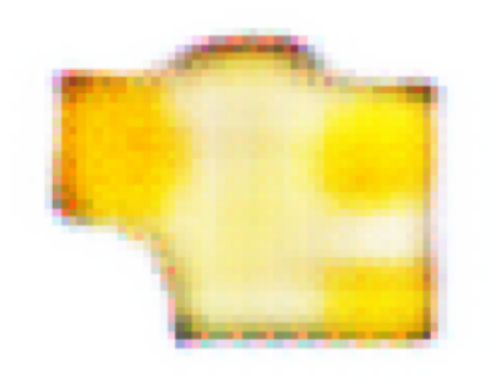

In [12]:
# ==========================================
# INFERENCE FUNCTION (Fixed Dimensions)
# ==========================================
def generate_floor_plan(text_prompt):
    if not dataloader: return
    print(f"\nGenerative Inference: '{text_prompt}'")

    transformer.eval()
    vqvae.eval()

    enc = tokenizer(text_prompt, return_tensors='pt', padding='max_length', max_length=64, truncation=True)
    text_ids = enc['input_ids'].to(cfg.device)

    indices = torch.tensor([[512]], device=cfg.device) # SOS

    with torch.no_grad():
        for _ in range(256):
            text_feat = transformer.text_emb(text_ids) + transformer.text_pos[:, :text_ids.shape[1], :]
            img_feat = transformer.img_emb(indices) + transformer.img_pos[:, :indices.shape[1], :]

            full_seq = torch.cat([text_feat, img_feat], dim=1)
            out = transformer.transformer(full_seq, full_seq)
            last_logit = transformer.fc_out(out[:, -1, :])

            # FIX: Dimension mismatch error solved here
            next_idx = torch.argmax(last_logit, dim=-1).unsqueeze(1) # (1, 1)
            indices = torch.cat([indices, next_idx], dim=1)

    vectors = vqvae.quantizer.embedding(indices[:, 1:])
    vectors = vectors.permute(0, 2, 1).view(1, 64, 16, 16)
    img = vqvae.decoder(vectors).squeeze().permute(1,2,0).cpu().numpy()

    plt.figure(figsize=(5,5))
    plt.imshow(np.clip((img*0.5)+0.5, 0, 1))
    plt.axis('off')
    plt.show()

# TEST
if dataloader:
    generate_floor_plan("bedroom with attached bath")
